# LAB 7A - TIME SERIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sales = pd.read_csv('sales.csv')
sales.info()
sales.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781 entries, 0 to 780
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Sales          781 non-null    int64 
 1   Date           781 non-null    object
 2   Promo          781 non-null    int64 
 3   SchoolHoliday  781 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 24.5+ KB


,Sales,Date,Promo,SchoolHoliday
0,5530,2013-01-02,0,1
1,4327,2013-01-03,0,1
2,4486,2013-01-04,0,1
3,4997,2013-01-05,0,1
4,7176,2013-01-07,1,1
5,5580,2013-01-08,1,1
6,5471,2013-01-09,1,1
7,4892,2013-01-10,1,1
8,4881,2013-01-11,1,1
9,4952,2013-01-12,0,0


Convert date to a data type that can be handled more effectively:

In [3]:
sales['Date'] = pd.to_datetime(sales['Date'], infer_datetime_format=True)
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781 entries, 0 to 780
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Sales          781 non-null    int64         
 1   Date           781 non-null    datetime64[ns]
 2   Promo          781 non-null    int64         
 3   SchoolHoliday  781 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 24.5 KB


In [4]:
year = sales['Date'].dt.year
print(year.unique())

[2013 2014 2015]


Similar to `year`, from the datetime variable we can also extract `quarter`, `month`, `day`, `day_name`, etc.

### Sequential Split

We will split our trainig and test data according to chronological. For time series it's important not to incurr data leakage by splitting the dataset randomly.

In [5]:
sales_train = sales[sales['Date'].dt.year < 2015]
sales_test = sales[sales['Date'].dt.year >= 2015]

print(sales_train.shape, sales_test.shape)

(606, 4) (175, 4)


In [6]:
def plot_entire_series(x, y, **kwargs):
    
    plt.figure(figsize=(16, 4))
    plt.plot(x, y, linewidth=2, color='black')
    
    for key, value in kwargs.items():
        plt.plot(x, value, linewidth=2, color=key)
        
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Sales', fontsize=16)
    plt.show()
    
    return None

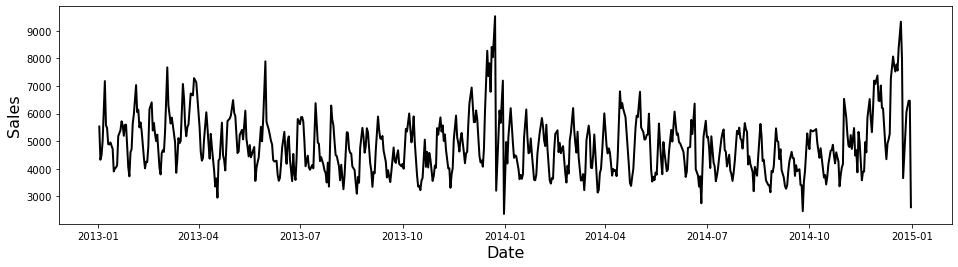

In [7]:
# We pass the data to matplotlib as numpy arrays simply to avoid warnings
x = sales_train['Date'].to_numpy()
y = sales_train['Sales'].to_numpy()

plot_entire_series(x, y)

## Linear Trend Model

In [8]:
time_period = list(range(len(sales_train)))

sales_train_lm = sales_train.copy()
sales_train_lm['TimePeriod'] = time_period
sales_train_lm.tail()

,Sales,Date,Promo,SchoolHoliday,TimePeriod
601,3659,2014-12-24,0,1,601
602,6057,2014-12-27,0,1,602
603,6463,2014-12-29,0,1,603
604,6466,2014-12-30,0,1,604
605,2605,2014-12-31,0,1,605


In [9]:
import statsmodels.formula.api as smf

lm = smf.ols(formula='Sales ~ TimePeriod', data=sales_train_lm).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8374
Date:                Thu, 17 Dec 2020   Prob (F-statistic):              0.361
Time:                        18:28:10   Log-Likelihood:                -5076.3
No. Observations:                 606   AIC:                         1.016e+04
Df Residuals:                     604   BIC:                         1.017e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4893.6771     85.450     57.270      0.0

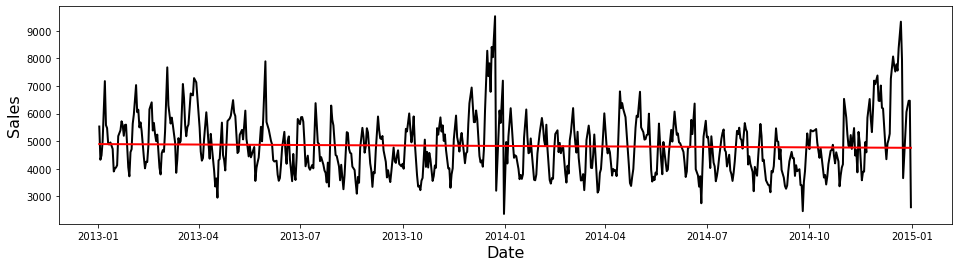

In [10]:
x = sales_train['Date'].to_numpy()
y = sales_train['Sales'].to_numpy()
y_pred = lm.predict(sales_train_lm).to_numpy()

plot_entire_series(x, y, red=y_pred)

## Random Walk Model

In [11]:
sales_train_rw = sales_train.copy()

sales_train_rw['SalesYesterday'] = sales_train['Sales'].shift(1)
sales_train_rw.head()

,Sales,Date,Promo,SchoolHoliday,SalesYesterday
0,5530,2013-01-02,0,1,NaN
1,4327,2013-01-03,0,1,5530.0
2,4486,2013-01-04,0,1,4327.0
3,4997,2013-01-05,0,1,4486.0
4,7176,2013-01-07,1,1,4997.0


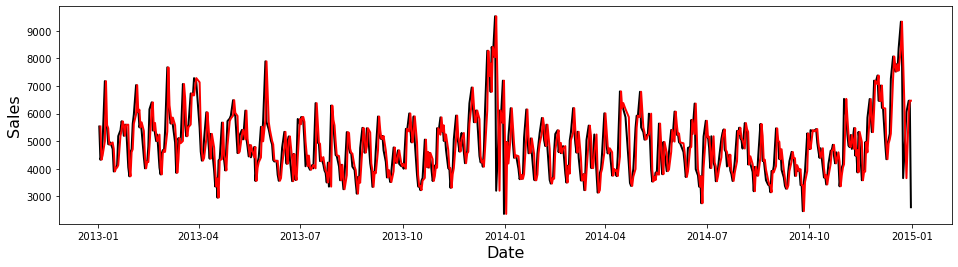

In [12]:
x = sales_train_rw['Date'].to_numpy()
y = sales_train_rw['Sales'].to_numpy()
y_pred = sales_train_rw['SalesYesterday'].to_numpy()

plot_entire_series(x, y, red=y_pred)

Lets look at the last 50 predictions

In [13]:
def plot_last_fifty(x, y, **kwargs):
    
    plt.figure(figsize=(16, 4))
    plt.scatter(x[-50:], y[-50:], linewidth=3, color='black')
    plt.plot(x[-50:], y[-50:], linewidth=3, color='black')
    
    for key, value in kwargs.items():
        plt.plot(x[-50:], value[-50:], linewidth=3, color=key)
        
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Sales', fontsize=16)
    plt.show()
    
    return None

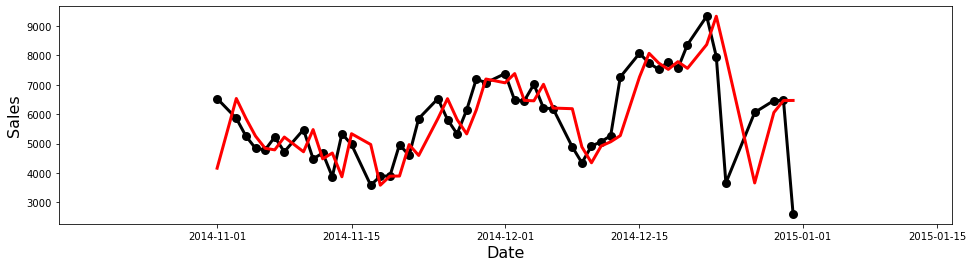

In [14]:
plot_last_fifty(x, y, red=y_pred)

In [15]:
print((abs(sales_train_rw['Sales'] - sales_train_rw['SalesYesterday']) >= 1000).value_counts())

False    516
True      90
dtype: int64


In [16]:
from sklearn.metrics import r2_score

# Here we slice the series using [1:] in order to discard the first entry which corresponds to a NaN.

print('Training R2:', round(r2_score(sales_train_rw['Sales'][1:], sales_train_rw['SalesYesterday'][1:]), 5))

Training R2: 0.3744


## Autoregressive Model

In [17]:
sales_train_ar = sales_train_rw.copy()

ar = smf.ols(formula='Sales ~ SalesYesterday', data=sales_train_ar).fit()

print(ar.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     536.5
Date:                Thu, 17 Dec 2020   Prob (F-statistic):           2.18e-85
Time:                        18:28:11   Log-Likelihood:                -4876.1
No. Observations:                 605   AIC:                             9756.
Df Residuals:                     603   BIC:                             9765.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1499.8007    146.896     10.

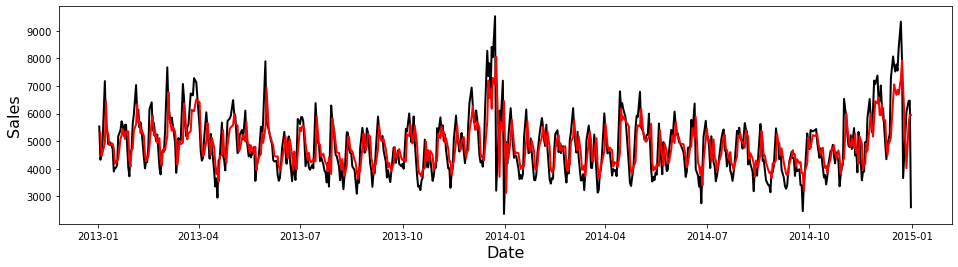

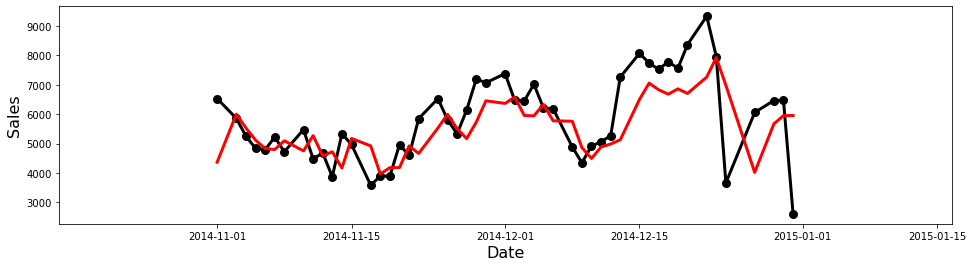

In [18]:
x = sales_train_ar['Date'].to_numpy()
y = sales_train_ar['Sales'].to_numpy()
y_pred = ar.predict(sales_train_ar).to_numpy()

plot_entire_series(x, y, red=y_pred)
plot_last_fifty(x, y, red=y_pred)

In [19]:
print((abs(sales_train_ar['Sales'] - ar.predict(sales_train_ar)) >= 1000).value_counts())

False    523
True      83
dtype: int64


## Higher-Order Auto-Regressive Model

In [20]:
sales_train_ar['SalesTwoDaysAgo'] = sales_train['Sales'].shift(2)

ar2 = smf.ols(formula='Sales ~ SalesYesterday + SalesTwoDaysAgo', data=sales_train_ar).fit()

print(ar2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     269.1
Date:                Thu, 17 Dec 2020   Prob (F-statistic):           3.41e-84
Time:                        18:28:12   Log-Likelihood:                -4867.5
No. Observations:                 604   AIC:                             9741.
Df Residuals:                     601   BIC:                             9754.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1454.8297    159.104     

**No significant improvement -- better to keep the simpler AR1 model**

### Incorporating Seasonality

In [21]:
sales_train_ar['Month'] = sales_train_ar['Date'].dt.month_name()
sales_train_ar['DayWeek'] = sales_train_ar['Date'].dt.day_name()
sales_train_ar.tail()

,Sales,Date,Promo,SchoolHoliday,SalesYesterday,SalesTwoDaysAgo,Month,DayWeek
601,3659,2014-12-24,0,1,7959.0,9331.0,December,Wednesday
602,6057,2014-12-27,0,1,3659.0,7959.0,December,Saturday
603,6463,2014-12-29,0,1,6057.0,3659.0,December,Monday
604,6466,2014-12-30,0,1,6463.0,6057.0,December,Tuesday
605,2605,2014-12-31,0,1,6466.0,6463.0,December,Wednesday


In [22]:
avg_sales_by_month = sales_train_ar.groupby('Month', sort=False).mean()['Sales']
avg_sales_by_month

Month
January      4754.711538
February     4910.520833
March        5130.117647
April        4761.244898
May          4915.416667
June         4610.750000
July         4641.407407
August       4326.867925
September    4220.882353
October      4414.192308
November     5067.607843
December     6248.857143
Name: Sales, dtype: float64

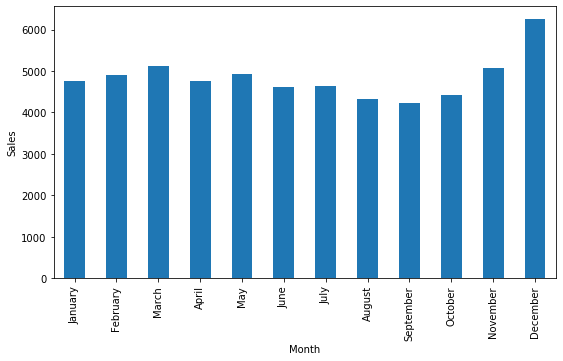

In [23]:
plt.figure(figsize=(9, 5))
avg_sales_by_month.plot(kind="bar")
plt.ylabel('Sales')
plt.xlabel('Month')
plt.show()

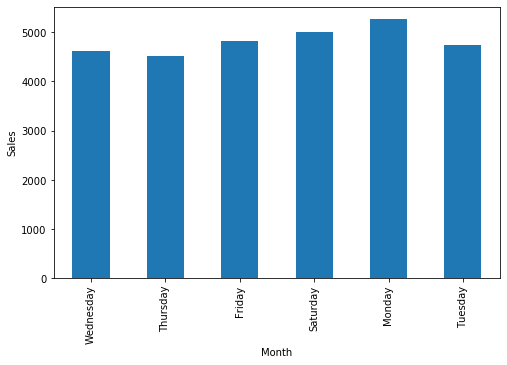

In [24]:
avg_sales_by_day = sales_train_ar.groupby('DayWeek', sort=False).mean()['Sales']

plt.figure(figsize=(8, 5))
avg_sales_by_day.plot(kind="bar")
plt.ylabel('Sales')
plt.xlabel('Month')
plt.show()

In [25]:
ar2 = smf.ols(formula='Sales ~ SalesYesterday + DayWeek + Month', data=sales_train_ar).fit()

print(ar2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     42.48
Date:                Thu, 17 Dec 2020   Prob (F-statistic):           1.72e-90
Time:                        18:28:12   Log-Likelihood:                -4826.0
No. Observations:                 605   AIC:                             9688.
Df Residuals:                     587   BIC:                             9767.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1989.3621 

In [26]:
# Create separate variable for December, since it's the only month significantly different from January

sales_train_ar['MonthDecember'] = np.where(sales_train_ar['Month'] == 'December', 1, 0)

ar3 = smf.ols(formula='Sales ~ SalesYesterday + DayWeek + MonthDecember', data=sales_train_ar).fit()

print(ar3.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     100.2
Date:                Thu, 17 Dec 2020   Prob (F-statistic):           1.93e-96
Time:                        18:28:12   Log-Likelihood:                -4833.6
No. Observations:                 605   AIC:                             9683.
Df Residuals:                     597   BIC:                             9718.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1812.9408 

In [27]:
# Add Promo and SchoolHoliday as well

ar4 = smf.ols(formula='Sales ~ SalesYesterday + DayWeek + MonthDecember + Promo + SchoolHoliday',
              data=sales_train_ar).fit()

print(ar4.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     113.6
Date:                Thu, 17 Dec 2020   Prob (F-statistic):          4.82e-123
Time:                        18:28:12   Log-Likelihood:                -4766.1
No. Observations:                 605   AIC:                             9552.
Df Residuals:                     595   BIC:                             9596.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             2403.9892 

In [28]:
# Remove SchoolHoliday

ar5 = smf.ols(formula='Sales ~ SalesYesterday + DayWeek + MonthDecember + Promo', data=sales_train_ar).fit()

print(ar5.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     127.3
Date:                Thu, 17 Dec 2020   Prob (F-statistic):          1.24e-123
Time:                        18:28:13   Log-Likelihood:                -4767.2
No. Observations:                 605   AIC:                             9552.
Df Residuals:                     596   BIC:                             9592.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             2379.3166 

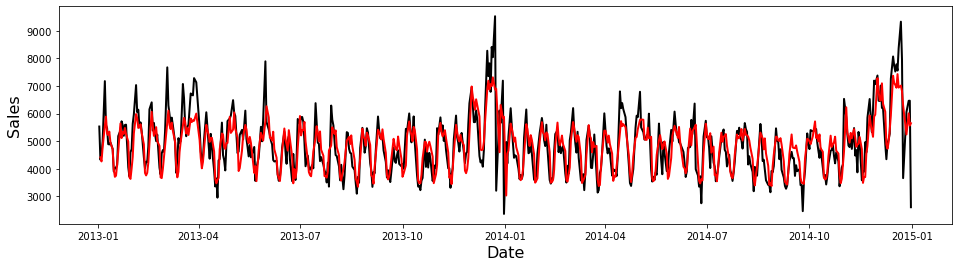

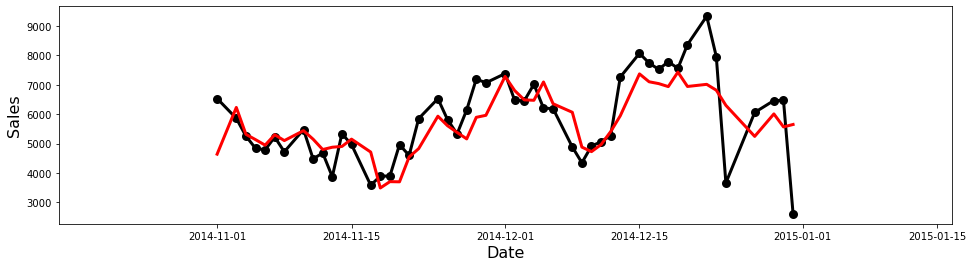

In [29]:
y_pred = ar5.predict(sales_train_ar).to_numpy()

plot_entire_series(x, y, red=y_pred)
plot_last_fifty(x, y, red=y_pred)

## Random Forest Regressor

In [30]:
sales_train_rf = sales_train_ar.drop(['Date', 'MonthDecember'], axis=1).copy()
sales_train_rf['Month'] = sales_train['Date'].dt.month
sales_train_rf['DayWeek'] = sales_train['Date'].dt.dayofweek

sales_train_rf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 606 entries, 0 to 605
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Sales            606 non-null    int64  
 1   Promo            606 non-null    int64  
 2   SchoolHoliday    606 non-null    int64  
 3   SalesYesterday   605 non-null    float64
 4   SalesTwoDaysAgo  604 non-null    float64
 5   Month            606 non-null    int64  
 6   DayWeek          606 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 37.9 KB


In [31]:
from sklearn.ensemble import RandomForestRegressor

# Again we slice [2:] to discard the entries with NaN.

y_train_rf = sales_train_rf['Sales'].iloc[2:]
X_train_rf = sales_train_rf.drop(['Sales'], axis=1).iloc[2:]

rf = RandomForestRegressor(max_features=5, min_samples_leaf=5, n_estimators = 500, random_state=88)
rf.fit(X_train_rf, y_train_rf)

RandomForestRegressor(max_features=5, min_samples_leaf=5, n_estimators=500,
                      random_state=88)

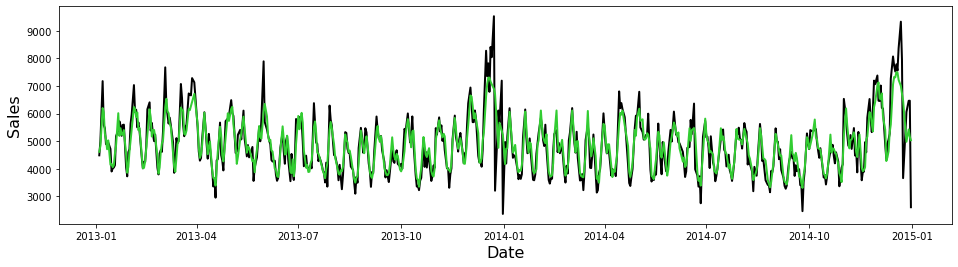

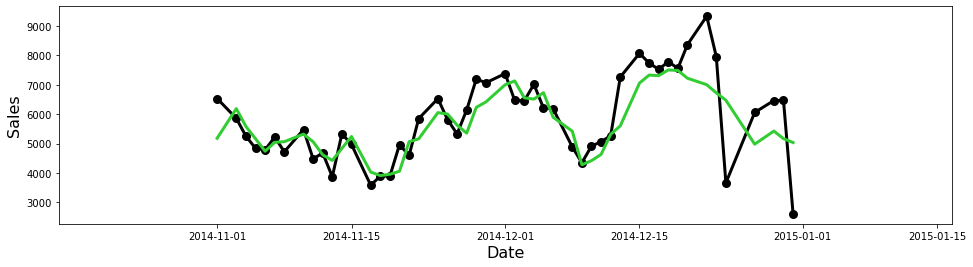

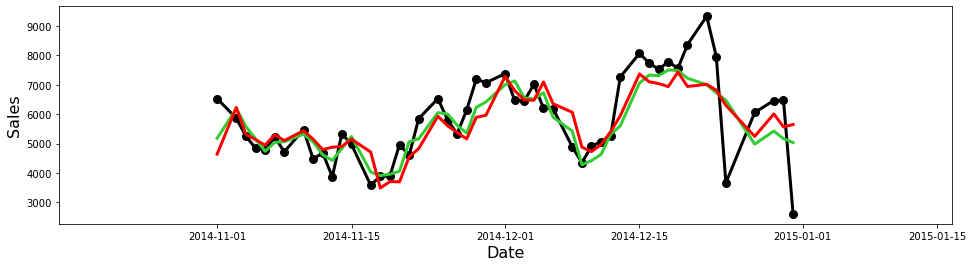

In [32]:
x = sales_train_ar['Date'].iloc[2:].to_numpy()
y = y_train_rf.to_numpy()
y_pred_rf = rf.predict(X_train_rf)
y_pred_ar = ar5.predict(sales_train_ar).to_numpy()

plot_entire_series(x, y, limegreen=y_pred_rf)
plot_last_fifty(x, y, limegreen=y_pred_rf)
plot_last_fifty(x, y, limegreen=y_pred_rf, red=y_pred_ar)

### Evaluation on Test Set

Create the test set with the extra columns. Note that we could have avoided the duplication effort in building
sales_train_rf and sales_test_rf by first adding all our variables to "sales" (our original data frame) 
and then splitting it.

In [33]:
## Random Forest on test set

sales_test_rf = sales_test.copy()
sales_test_rf['SalesYesterday'] = sales_test_rf['Sales'].shift(1)
sales_test_rf['SalesTwoDaysAgo'] = sales_test_rf['Sales'].shift(2)
sales_test_rf['Month'] = sales_test_rf['Date'].dt.month
sales_test_rf['DayWeek'] = sales_test_rf['Date'].dt.dayofweek
sales_test_rf = sales_test_rf.drop(['Date'], axis=1)

y_test_rf = sales_test_rf['Sales'].iloc[2:]
X_test_rf = sales_test_rf.drop(['Sales'], axis=1).iloc[2:]

y_pred_rf = rf.predict(X_test_rf)
print('Random Forest OSR2:', round(r2_score(y_test_rf, y_pred_rf), 5))

Random Forest OSR2: 0.6632


In [34]:
## Auto-regressive Model on test set

sales_test_ar = sales_test.copy()
sales_test_ar['SalesYesterday'] = sales_test_ar['Sales'].shift(1)
sales_test_ar['SalesTwoDaysAgo'] = sales_test_ar['Sales'].shift(2)
sales_test_ar['Month'] = sales_test_ar['Date'].dt.month_name()
sales_test_ar['DayWeek'] = sales_test_ar['Date'].dt.day_name()
sales_test_ar['MonthDecember'] = np.where(sales_test_ar['Month'] == 'December', 1, 0)

y_test_ar = sales_test_ar['Sales'][1:]

y_pred_ar = ar5.predict(sales_test_ar)[1:]
print('Auto-regressive Model OSR2:', round(r2_score(y_test_ar, y_pred_ar), 5))

Auto-regressive Model OSR2: 0.5885


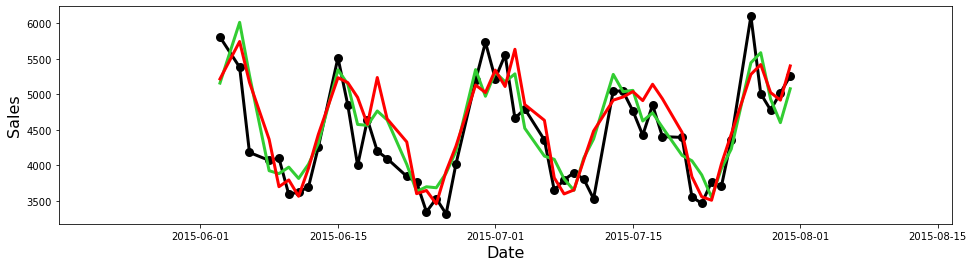

In [35]:
x = sales_test['Date'].iloc[2:].to_numpy()
y = y_test_rf.to_numpy()

plot_last_fifty(x, y, limegreen=y_pred_rf, red=y_pred_ar.to_numpy())